# Battle of neighborhoods week 2

## INTRODUCTION

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2014, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

Throughout its history, New York City has been a major point of entry for immigrants; the term "melting pot" was coined to describe densely populated immigrant neighborhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. English remains the most widely spoken language, although there are areas in the outer boroughs in which up to 25% of people speak English as an alternate language, and/or have limited or no English language fluency. English is least spoken in neighborhoods such as Flushing, Sunset Park, and Corona.

With it's diverse culture , comes diverse food items. There are many restaurants in New york City, each beloning to different categories like Chinese , Indian , French etc.

So as part of this project , we will list and visualize all major parts of New York City that has great indian resturants.

## DATA

Data For this project we need the following data :

New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude. Data source : https://cocl.us/new_york_dataset Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city. Indian resturants in each neighborhood of new york city. Data source : Fousquare API Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only indian restaurants. GeoSpace data Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.

## APPROACH 

1.Collect the new york city data from https://cocl.us/new_york_dataset

2.Using FourSquare API we will find all venues for each neighborhood.

3.Filter out all venues that are Indian Resturants.

4.Find rating , tips and like count for each Indian Resturants using FourSquare API.

5.Using rating for each resturant , we will sort that data.

6.Visualize the Ranking of neighborhoods using folium library(python)


## Queries that can be answered using above dataset

1.What is best location in New York City for Indian Cuisine ?

2.Which areas have potential Indian Restaurant Market ?

3.Which all areas lack Indian Restaurants ?

4.Which is the best place to stay if I prefer Indian Cuisine ?

## ANALYSIS

### Required Libraries

> **pandas** and numpy for handling data.

> **request** module for using FourSquare API.

> **geopy** to get co-ordinates of City of New York.

> **folium** to visualize the results on a map

In [1]:
!pip install folium
!pip install lxml
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import urllib.request
import json
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium 

print('Libraries imported.')

Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'MKOD###################################T' # changed my Foursquare ID
    CLIENT_SECRET = 'EQ##########################################OQ' # changed Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '#################################################' # i have changed the id with ##
    CLIENT_SECRET = 'EQC###########################Q' # i have changed the secret with ##
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [10]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [11]:
# get new york data
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [12]:
new_york_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York

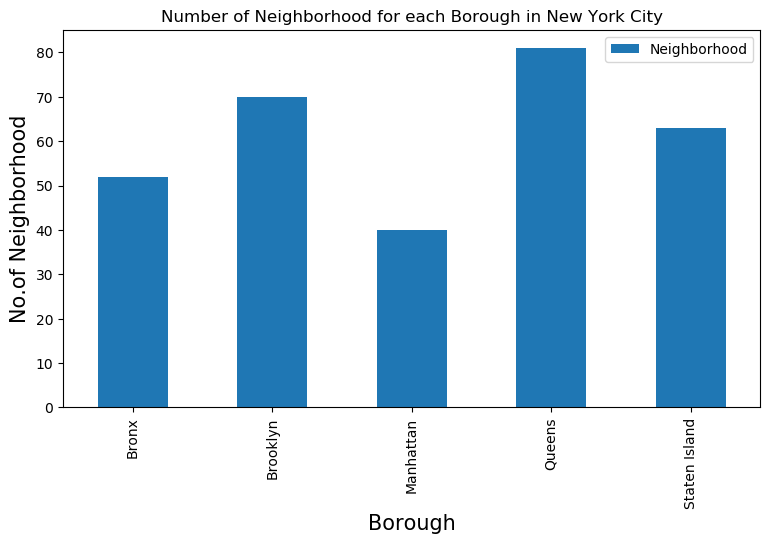

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect Indian restaurants for each Neighborhood

In [49]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) Indian Restaurants in Wakefield, Bronx:0
done
( 2 / 306 ) Indian Restaurants in Co-op City, Bronx:0
done
( 3 / 306 ) Indian Restaurants in Eastchester, Bronx:0
done
( 4 / 306 ) Indian Restaurants in Fieldston, Bronx:0
done
( 5 / 306 ) Indian Restaurants in Riverdale, Bronx:0
done
( 6 / 306 ) Indian Restaurants in Kingsbridge, Bronx:0
done
( 7 / 306 ) Indian Restaurants in Marble Hill, Manhattan:0
done
( 8 / 306 ) Indian Restaurants in Woodlawn, Bronx:1
done
( 9 / 306 ) Indian Restaurants in Norwood, Bronx:0
done
( 10 / 306 ) Indian Restaurants in Williamsbridge, Bronx:0
done
( 11 / 306 ) Indian Restaurants in Baychester, Bronx:0
done
( 12 / 306 ) Indian Restaurants in Pelham Parkway, Bronx:0
done
( 13 / 306 ) Indian Restaurants in City Island, Bronx:0
done
( 14 / 306 ) Indian Restaurants in Bedford Park, Bronx:0
done
( 15 / 306 ) Indian Restaurants in University Heights, Bronx:0
done
( 16 / 306 ) Indian Restaurants in Morris Heights, Bronx:0
done
( 17 / 306 ) Indian Re

done
( 130 / 306 ) Indian Restaurants in Astoria, Queens:2
done
( 131 / 306 ) Indian Restaurants in Woodside, Queens:7
done
( 132 / 306 ) Indian Restaurants in Jackson Heights, Queens:7
done
( 133 / 306 ) Indian Restaurants in Elmhurst, Queens:4
done
( 134 / 306 ) Indian Restaurants in Howard Beach, Queens:0
done
( 135 / 306 ) Indian Restaurants in Corona, Queens:0
done
( 136 / 306 ) Indian Restaurants in Forest Hills, Queens:0
done
( 137 / 306 ) Indian Restaurants in Kew Gardens, Queens:2
done
( 138 / 306 ) Indian Restaurants in Richmond Hill, Queens:7
done
( 139 / 306 ) Indian Restaurants in Flushing, Queens:0
done
( 140 / 306 ) Indian Restaurants in Long Island City, Queens:2
done
( 141 / 306 ) Indian Restaurants in Sunnyside, Queens:1
done
( 142 / 306 ) Indian Restaurants in East Elmhurst, Queens:0
done
( 143 / 306 ) Indian Restaurants in Maspeth, Queens:0
done
( 144 / 306 ) Indian Restaurants in Ridgewood, Queens:1
done
( 145 / 306 ) Indian Restaurants in Glendale, Queens:0
done
(

done
( 255 / 306 ) Indian Restaurants in Concord, Staten Island:0
done
( 256 / 306 ) Indian Restaurants in Emerson Hill, Staten Island:0
done
( 257 / 306 ) Indian Restaurants in Randall Manor, Staten Island:0
done
( 258 / 306 ) Indian Restaurants in Howland Hook, Staten Island:0
done
( 259 / 306 ) Indian Restaurants in Elm Park, Staten Island:0
done
( 260 / 306 ) Indian Restaurants in Remsen Village, Brooklyn:0
done
( 261 / 306 ) Indian Restaurants in New Lots, Brooklyn:0
done
( 262 / 306 ) Indian Restaurants in Paerdegat Basin, Brooklyn:0
done
( 263 / 306 ) Indian Restaurants in Mill Basin, Brooklyn:0
done
( 264 / 306 ) Indian Restaurants in Jamaica Hills, Queens:4
done
( 265 / 306 ) Indian Restaurants in Utopia, Queens:0
done
( 266 / 306 ) Indian Restaurants in Pomonok, Queens:0
done
( 267 / 306 ) Indian Restaurants in Astoria Heights, Queens:0
done
( 268 / 306 ) Indian Restaurants in Claremont Village, Bronx:0
done
( 269 / 306 ) Indian Restaurants in Concourse Village, Bronx:1
done


In [50]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [15]:
indian_rest_ny.shape

(10, 4)

We got 153 Indian Restaurants across New York City

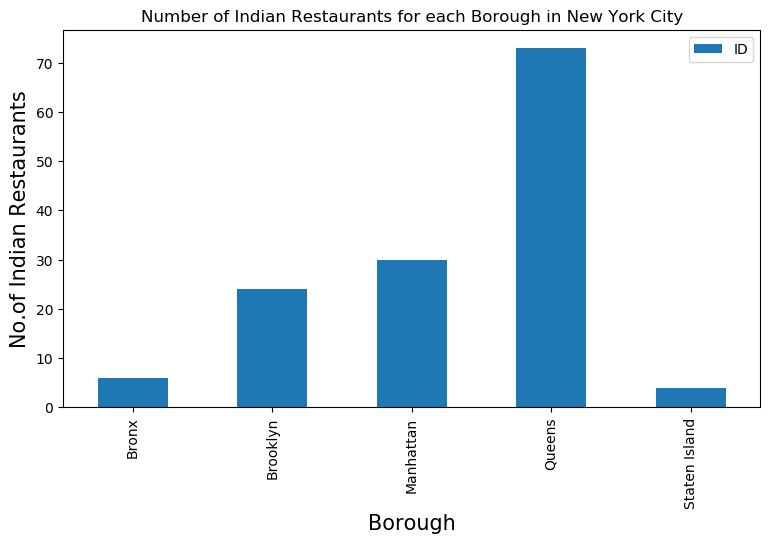

In [51]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has the largest number of indian restaurants

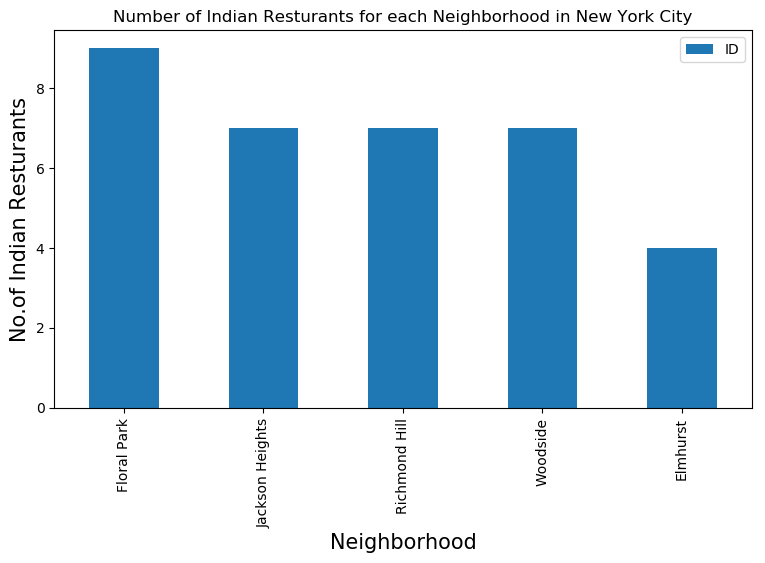

In [52]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [53]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
96,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
97,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
98,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
99,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
100,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
101,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
102,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
103,Queens,Floral Park,4c953a7672dd224bd8d1a191,Real Usha Sweets & Snacks Inc.
104,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


So Floral Park in Queens has the highest number of Indian Restaurants with a total count of 9.

Now we will get the ranking of each resturant for further analysis.

In [54]:
# prepare neighborhood list that contains indian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these restaurants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     8.0    10
( 1 / 137 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
( 2 / 137 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     5.9     9
( 3 / 137 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.7     3
( 4 / 137 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
( 5 / 137 ) processed
                         ID       Name  Likes  Rating  Tips
0  4b5a4dc8f964a520a2bb28e3  Taj Mahal     38     8.3    26
( 6 / 137 ) processed
                         ID          Name  Likes

KeyError: 'venue'

In [55]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,8.0,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.9,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.7,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2


In [56]:

indian_rest_stats_ny.shape

(40, 7)

In [57]:
indian_rest_ny.shape

(137, 4)

So we got data for all restaurants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [58]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv fileindian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [59]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [60]:
indian_rest_stats_ny_csv.shape

(40, 7)

In [61]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,8.0,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.9,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.7,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2


In [62]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
Borough         40 non-null object
Neighborhood    40 non-null object
ID              40 non-null object
Name            40 non-null object
Likes           40 non-null object
Rating          40 non-null float64
Tips            40 non-null object
dtypes: float64(1), object(6)
memory usage: 2.3+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [63]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [64]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [65]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
Borough         40 non-null object
Neighborhood    40 non-null object
ID              40 non-null object
Name            40 non-null object
Likes           40 non-null float64
Rating          40 non-null float64
Tips            40 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.3+ KB



Now the data types looks correct

In [66]:
# Restaurant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               9.1
Tips                                 148
Name: 37, dtype: object

In [67]:
# Restaurant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]


Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               9.1
Tips                                 148
Name: 37, dtype: object

In [68]:
# Restaurant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               9.1
Tips                                 148
Name: 37, dtype: object

In [69]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [70]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
25,Tribeca,9.1
19,Prospect Heights,8.8
16,Murray Hill,8.8
10,Fort Greene,8.7
28,West Village,8.7
4,Clinton Hill,8.7
8,East Village,8.6
23,South Side,8.5
22,Roosevelt Island,8.4
0,Bay Ridge,8.3


Above are the top neighborhoods with top average rating of Indian restaurants.

In [71]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [72]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.1125
1,Brooklyn,7.4000
0,Bronx,6.6400


Similarly these are the average rating of Indian Resturants for each Borough

Lets visualize it

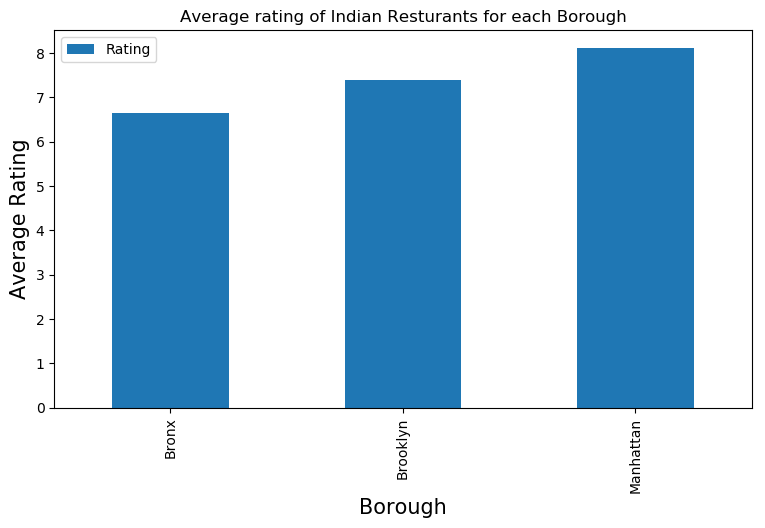

In [73]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [74]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [75]:

ny_neighborhood_stats

,Neighborhood,Average Rating
25,Tribeca,9.1


We will join this dataset to original new york data to get lonitude and latitude

In [76]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [77]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [78]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Tribeca,40.721522,-74.010683,9.1



Now we will show this data on a map

In [79]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)


In [80]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [81]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [82]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

## CONCLUSION

>Astoria(Queens), Blissville(Queens), Civic Center(Manhattan) are some of the best neighborhoods for indian cuisine.

>Manhattan have potential Indian Restaurant Market

>Staten Island ranks last in average rating of Indian Restaurants.

>Manhattan is the best place to stay if you prefer Indian Cuisine.

## LIMITATIONS

>The ranking is purely on basis of rating of restaurants

>The accuracy of data depends purely depends on the data provided by FourSquare